In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def display(func):
    def display_func(*args, **kwargs):
        img = func(*args, **kwargs)
        cvt_img = img
        plt.figure(figsize=(8, 8))
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        return img
    return display_func

In [3]:
@display
def load_img(*args, **kwargs):
    return cv2.imread(*args, **kwargs)

def run_pipeline(pipeline):
    curr_result = pipeline[0][0](*pipeline[0][1], **pipeline[0][2])
    for func, args, kwargs in pipeline[1:]:
        curr_result = func(curr_result, *args, **kwargs)

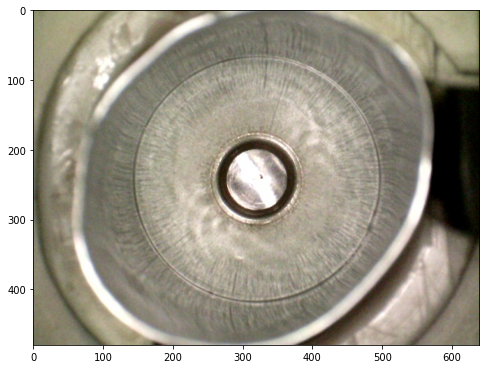

In [185]:
img = load_img('../img/Limpias/A150 - 20200630_085434.jpg')

In [186]:
@display
def find_main_circle(img):
    cvt_img = img
    if len(cvt_img.shape) == 3:
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cvt_img[cvt_img < 70] = 0
    circles = cv2.HoughCircles(cvt_img, cv2.HOUGH_GRADIENT, 1, 10, minRadius=40)
    radius_list = circles[0, :, 2]
    min_radius = np.min(radius_list)
    main_radius = min_radius
    #main_radius = np.min(radius_list[radius_list > 1.5 * min_radius])
    print(min_radius)
    print(len(circles))
    main_circle = circles[0, np.where(radius_list == main_radius)[0][0], :]
    img = img.copy()
    x, y, rad = main_circle
    cv2.circle(img, (x, y), rad, color=(255, 255, 255), thickness=5)
    cv2.circle(img, (x, y), int(4.2 * rad), color=(255, 255, 255), thickness=5)
    return img

@display
def find_edges(img, *args, **kwargs):
    cvt_img = img
    if len(cvt_img.shape) == 3:
        cvt_img = cv2.cvtColor(cvt_img, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(cvt_img, *args, **kwargs)

@display
def gamma_filter(img, gamma):
    return (255 * (img / 255) ** (1 / gamma)).astype(np.uint8)

@display
def equalizeHist(img):
    if len(img.shape) == 3:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return cv2.equalizeHist(img)

@display
def threshold(*args, **kwargs):
    ret, tresh = cv2.threshold(*args, **kwargs)
    return tresh

@display
def adaptThresh(*args, **kwargs):
    return cv2.adaptiveThreshold(*args, **kwargs)

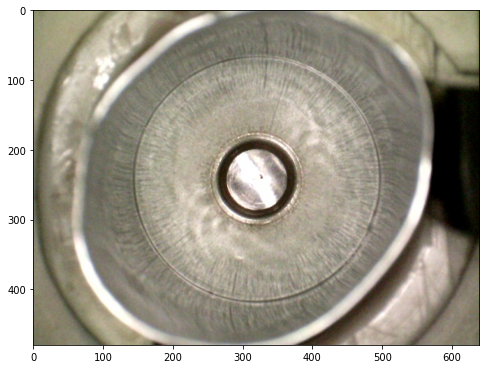

In [189]:
img = load_img('../img/Limpias/A150 - 20200630_085434.jpg')

55.7
1


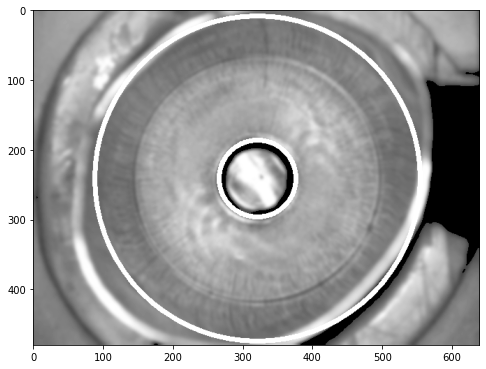

In [190]:
pipeline = [
    (cv2.cvtColor, (img, cv2.COLOR_BGR2GRAY), {}),
    #(equalizeHist, (), {}),
    #(gamma_filter, (img, 0.7), {}),
    (cv2.GaussianBlur, ((11, 11), ), {"sigmaX": 2, "sigmaY": 2}),
    #(threshold, (20, 255, cv2.THRESH_BINARY_INV), {}),
    #(display(cv2.morphologyEx), (cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8)), {}),
    #(cv2.ad, ((5, 5), ), {"sigmaX": 2, "sigmaY": 2}),
    #(adaptThresh, (255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 5), {}),
    #(display(cv2.morphologyEx), (cv2.MORPH_CLOSE, np.ones((3,3), np.uint8)), {}),
    #(display(cv2.morphologyEx), (cv2.MORPH_OPEN, np.ones((5,5), np.uint8)), {}),
    #(gamma_filter, (2, ), {}),
    #(equalizeHist, (), {}),
    #(find_edges, (120, 255), {'L2gradient': True}),
    (find_main_circle, (), {})
]
#for channel in range(3):
#    hist = cv2.calcHist([img], [channel], None, [256], [0, 256])
#    plt.plot(hist)
#    plt.show()
run_pipeline(pipeline)

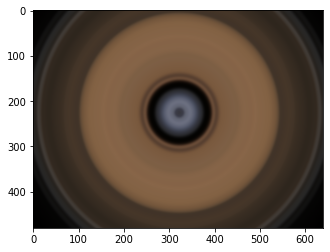

In [35]:
filtered_img = cv2.GaussianBlur(img, (5, 5), sigmaX=2, sigmaY=2)
cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(cvt_img, cv2.HOUGH_GRADIENT, 1, 20, minRadius=20)
radius_list = circles[0, :, 2]
min_radius = np.min(radius_list)
main_radius = min_radius
main_circle = circles[0, np.where(radius_list == main_radius)[0][0], :]
img = img.copy()
rows, cols, _ = filtered_img.shape
x, y, rad = main_circle
step = 1
filtered_img = np.float32(filtered_img)
average_img = np.float32(step / 360 * filtered_img)
for theta in range(0, 360, 1):
        M = cv2.getRotationMatrix2D((x, y), theta, step)
        rotated_img = cv2.warpAffine(filtered_img, M, (cols, rows))
        average_img = cv2.addWeighted(average_img, 1, rotated_img, step / 360, 0)
plt.imshow(cv2.cvtColor(np.uint8(average_img), cv2.COLOR_BGR2RGB))

array([[[0, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

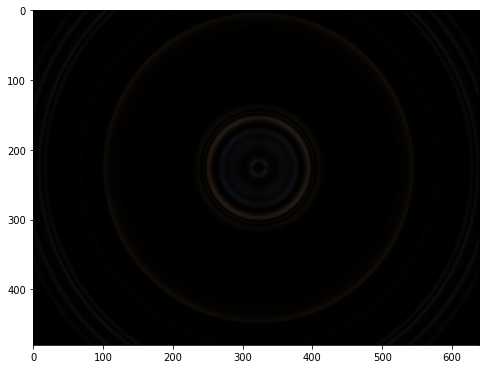

In [39]:
display(cv2.morphologyEx)(np.uint8(average_img), cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8))